In [1]:
import tensorflow as tf
import numpy as np
import itertools

In [2]:
HISTORY_TIMES = [4, 8, 16, 32, 48, 64, 96, 128]

PIECES = 32

ADDITIONAL_INPUT_SIZE = 6

In [3]:
tf.reset_default_graph()

# Training Parameters
learning_rate = tf.constant(0.001, dtype=tf.float32)
batch_size = 100
epsilon = 1e-06

num_keys = 12

# Network Parameters
num_input = 12 + ADDITIONAL_INPUT_SIZE      # dimension of one input at moment
num_hidden_local = 100
num_hidden_read = 100
num_hidden_aggreg = 100
num_nonreccurent1 = 200
num_nonreccurent2 = 400
num_nonreccurent3 = 800
num_output = 2**num_keys

num_hidden_decoder = 100
num_decoder_output = 88

# tf graph input
X = tf.placeholder(dtype=tf.float32, shape=[batch_size, None, num_input])
Y = tf.placeholder(dtype=tf.float32, shape=[batch_size, None, num_output])
History = tf.placeholder(dtype=tf.float32, shape=[batch_size, None, len(HISTORY_TIMES), num_keys])

with tf.variable_scope("local"):
    local_lstm = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(num_hidden_local, forget_bias=1.0, use_peepholes=True)])
    local_lstm_outputs, _ = tf.nn.dynamic_rnn(local_lstm, X[:, :-1], dtype=tf.float32)

with tf.variable_scope("global"):
    read_lstm = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(num_hidden_read, forget_bias=1.0, use_peepholes=True)])
    read_lstm_outputs, _ = tf.nn.dynamic_rnn(read_lstm, 
                tf.concat([X[:, :-1], tf.reshape(History[:, :-1], [batch_size, -1, len(HISTORY_TIMES) * num_keys])], axis=2), 
                                             dtype=tf.float32)
read_index = tf.nn.softmax(tf.layers.dense(read_lstm_outputs, len(HISTORY_TIMES), activation=None))
read = tf.reduce_mean(tf.expand_dims(read_index, 3) * History[:, 1:], axis=2)

with tf.variable_scope("aggreg"):
    aggreg_lstm = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(num_hidden_aggreg, forget_bias=1.0, use_peepholes=True)])
    aggreg_lstm_outputs, _ = tf.nn.dynamic_rnn(aggreg_lstm, tf.concat([read, local_lstm_outputs], axis=2), dtype=tf.float32)

nonrec = tf.contrib.rnn.MultiRNNCell([
    tf.contrib.rnn.BasicRNNCell(num_nonreccurent1),
    tf.contrib.rnn.BasicRNNCell(num_nonreccurent2),
    tf.contrib.rnn.BasicRNNCell(num_nonreccurent3),
])
nonrec_outputs, _ = tf.nn.dynamic_rnn(nonrec, aggreg_lstm_outputs, dtype=tf.float32)
    
p = tf.nn.softmax(tf.layers.dense(nonrec_outputs, num_output, activation=None))

ce = -tf.log(p) * Y[:, 1:] - tf.log(1 - p) * (1 - Y[:, 1:])
loss_op = tf.reduce_mean(ce)

# DECODER PART:

DecodedX = tf.placeholder(dtype=tf.float32, shape=[batch_size, None, num_decoder_output])
DecoderInput = tf.concat([DecodedX[:, :-1], X[:, 1:]], axis=2)
with tf.variable_scope("decoder"):
    decoder_lstm = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(num_hidden_decoder, forget_bias=1.0)])
    decoder_lstm_outputs, _ = tf.nn.dynamic_rnn(decoder_lstm, tf.concat([DecodedX[:, :-1], X[:, 1:]], axis=2), dtype=tf.float32)

decoder_p = tf.layers.dense(decoder_lstm_outputs, num_decoder_output, activation=None)

decoder_ce = tf.nn.sigmoid_cross_entropy_with_logits(logits=decoder_p, labels=DecodedX[:, 1:])
loss_op += tf.reduce_mean(decoder_ce * 
            tf.tile(X[:, 1:, :-ADDITIONAL_INPUT_SIZE], [1,1,8])[:,:,:num_decoder_output])
    
# define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
gvs = optimizer.compute_gradients(loss_op)
capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
train_op = optimizer.apply_gradients(capped_gvs)

#optimizing
#train_op = tf.contrib.layers.optimize_loss(
#                loss_op, tf.train.get_global_step(), optimizer=optimizer, learning_rate=learning_rate)

init = tf.global_variables_initializer()

In [4]:
# Start training
config = tf.ConfigProto(log_device_placement=True)  # to output is variable on gpu or cpu
config.gpu_options.per_process_gpu_memory_fraction = 0.6  # BlasGEMM launch failed error fix (seems like not enopugh memory on gpu)
sess = tf.Session(config = config)
saver = tf.train.Saver()

In [5]:
# Run the initializer
sess.run(init)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def drawNotes(song, title="", scale=(None, None)):
    if scale[0] is None:
        scale = (song.shape[0] / 10, song.shape[1] / 10)
    
    plt.figure(figsize=scale)
    plt.imshow(song.T, aspect='auto', origin='lower')
    plt.title(title)
    plt.xlabel("time")
    plt.xticks(np.arange(0, song.shape[0], 4))
    plt.show()

In [7]:
songs = np.load("CP_dataset.npy")

In [8]:
times = [np.array(t) for t in itertools.product([0, 1], repeat=ADDITIONAL_INPUT_SIZE)]*1000

In [9]:
def transform(song, stack_zeros=True):    
    wh = song[:, :12]
    for i in range(1,7):
        wh = np.logical_or(wh, song[:, 12*i:12*i+12])
    
    temp = wh.copy()
    for t in HISTORY_TIMES:
        h = np.roll(temp, t, axis=0)
        h[:t] = 0
        wh = np.concatenate([wh, h], axis=1)
          
    wh = np.concatenate([wh, times[:song.shape[0]]], axis=1)
            
    return wh

hsongs = []
decoded = []
for song in songs:
    t = transform(song)
    for i in range(0, t.shape[0] - PIECES, 32):
        hsongs.append(t[i:i+PIECES])
        decoded.append(song[i:i+PIECES])
hsongs = np.array(hsongs)
decoded = np.array(decoded)

In [10]:
def generateBatch():
    # выбираем фрагменты для батча
    indexes = np.random.choice(np.arange(len(hsongs)), batch_size)
    batch, decoded_batch = hsongs[indexes], decoded[indexes]
    
    # преобразуем фичи в двумерные, чтобы по одной оси были октавы по 12 клавиш
    tbatch = batch[:, :, :-ADDITIONAL_INPUT_SIZE].reshape((batch_size, PIECES, -1, 12))
    
    # на сколько нужно всё сдвинуть рандомно; зануляем лишнее (костыль)
    to_roll = np.random.randint(-6, 6)
    if to_roll > 0:
        decoded_batch[:, :, -to_roll:] = 0
    else:
        decoded_batch[:, :, :-to_roll] = 0
    
    # роллим
    tbatch = np.roll(tbatch, to_roll, axis=3)
    decoded_batch = np.roll(decoded_batch, to_roll, axis=2)
    
    # преобразуем обратно в одномерное пространство, не забывая подсоединить Additional Input
    ans = np.concatenate([tbatch.reshape((batch_size, PIECES, -1)), batch[:, :, -ADDITIONAL_INPUT_SIZE:]], axis=2)
    
    # преобразуем в 4096:
    ohe = np.zeros((batch_size * PIECES, 4096))
    ohe[np.arange(batch_size * PIECES), ans[:, :, :12].reshape(-1, 12).dot(2**np.arange(12))] = 1
    
    return (np.concatenate([ans[:, :, :12], ans[:, :, -ADDITIONAL_INPUT_SIZE:]], axis=2),  # вход + additional input
            ans[:, :, 12:-ADDITIONAL_INPUT_SIZE].reshape(batch_size, PIECES, len(HISTORY_TIMES), 12),  # история
            ohe.reshape(batch_size, PIECES, 4096),
            decoded_batch)  # ответ

In [11]:
saver.restore(sess, "./tmp/100-100-100 HistoryUserScheme LSTM collapsed CP_dataset songs by fragments 8-history 200-400-800-4096 100-decoder lr=0.001.ckpt")

INFO:tensorflow:Restoring parameters from ./RealData First Model/tmp/100-100-100 HistoryUserScheme LSTM collapsed CP_dataset songs by fragments 8-history 200-400-800-4096 100-decoder lr=0.001.ckpt


0.00227572  mean for last:  0.00227572


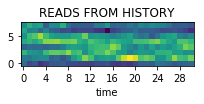

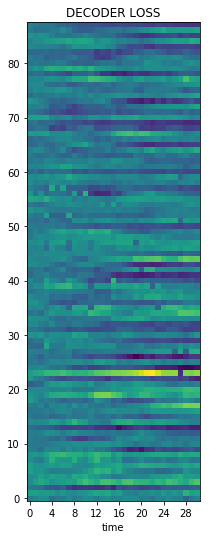

0.00116697  mean for last:  0.00125441
0.00108731  mean for last:  0.00112364
0.00112625  mean for last:  0.00111549
0.00112511  mean for last:  0.00111893


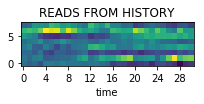

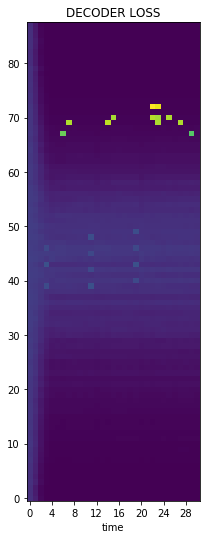

0.00110784  mean for last:  0.00111455
0.00111552  mean for last:  0.00111668
0.00110955  mean for last:  0.00111303
0.00112377  mean for last:  0.00112248


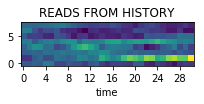

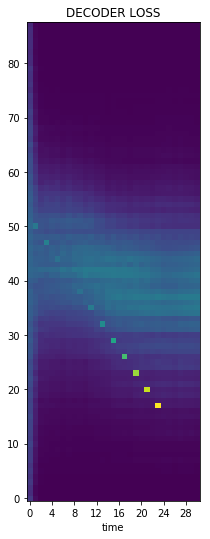

0.00108617  mean for last:  0.00111907


In [ ]:
training_steps = 200000
display_step = 50

RECORD = 10

losses = []
for step in range(training_steps + 1):
    # getting data
    batch_x, batch_h, batch_y, batch_d = generateBatch()
    # Run optimization step
    fd = {X: batch_x, History: batch_h, Y: batch_y, DecodedX: batch_d}
    _, L = sess.run([train_op, ce], feed_dict=fd)
    losses.append(L.mean())
    
    if np.isnan(L).any():
        print(" DAMN NAN ERROR")
        break
        
    if step % display_step == 0:
        print(L.mean(), " mean for last: ", np.array(losses)[-display_step:].mean())
        #drawNotes(L[0].T, "LOSS")
        
        if step % 200 == 0:
            r = sess.run(read_index, feed_dict=fd)
            drawNotes(r[0], "READS FROM HISTORY")
            
            sn = sess.run(decoder_ce, feed_dict=fd)
            drawNotes(sn[0], "DECODER LOSS")
           
    if len(losses) > display_step and np.array(losses)[-display_step:].mean() < RECORD:
        RECORD = np.array(losses)[-display_step:].mean()
        saver.save(sess, "./tmp/100-100-100 HistoryUserScheme LSTM collapsed CP_dataset songs by fragments 8-history 200-400-800-4096 100-decoder lr=0.001.ckpt")
        
print("Optimization Finished!")

0.0011004


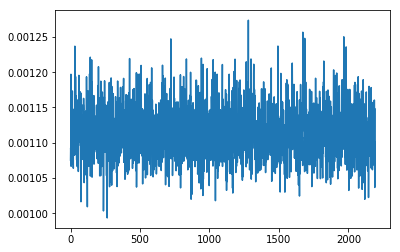

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

print(RECORD)
plt.plot(losses)  # 4096

In [12]:
import mido
from mido import MidiFile
import numpy as np
import copy
import math

import matplotlib.pyplot as plt
%matplotlib inline

# для возможности прослушивания midi прямо в ноутбуке
HEARING_PORT = mido.open_output()
# для вывода массивов numpy целиком
np.set_printoptions(threshold=np.nan)

BASE_NOTE = 21
KEYS = 88
FREQ = 4  #ticks for beat

def drawSong(song, scale=(None, None)):
    if scale[0] is None:
        scale = (song.notes.shape[0] / 10, song.notes.shape[1] / 10)
    
    plt.figure(figsize=scale)
    plt.title(song.name)
    plt.imshow(song.notes.T, aspect='auto', origin='lower')
    plt.xlabel("time")
    plt.xticks(np.arange(0, song.notes.shape[0], 4))
    plt.show()

# Класс для создания нового миди файла
class MySong:
    def __init__(self, played_lines=[], finished=False):
        self.name = "Generated song!"
        self.notes = np.zeros((0, 88))

        self.mid = MidiFile(type=0)
        self.track = mido.MidiTrack()
        self.mid.tracks.append(self.track)

        self.time_passed = 0
        self.release = []

        for line in played_lines:
            self.add(line)
           
        if finished:
            self.finish()

    # добавление новых строк в ноты
    def add(self, played):
        self.notes = np.vstack([self.notes, played])

        # "отпуск" нот, сыгранных долю назад
        if played.sum() > 0:
            for i in self.release:
                self.track.append(mido.Message('note_on', note=BASE_NOTE + i, velocity=0, time=self.time_passed))
                self.time_passed = 0
            self.release = []

        # добавление новых нот
        for i, key in enumerate(played):
            if key == 1:
                self.track.append(mido.Message('note_on', note=BASE_NOTE + i, velocity=64, time=self.time_passed))
                self.time_passed = 0
                self.release.append(i)
        self.time_passed += self.mid.ticks_per_beat // FREQ

    # должна быть вызвана в конце создания файла
    def finish(self):
        for i in self.release:
            self.track.append(mido.Message('note_off', note=BASE_NOTE + i, velocity=64, time=self.time_passed))
            self.time_passed = 0
        self.track.append(mido.Message('note_off', note=BASE_NOTE, velocity=0, time=self.time_passed))

    # воспроизведение
    def play(self):
        for msg in self.mid.play():
            HEARING_PORT.send(msg)

    # сохранение
    def save_file(self, name):
        self.mid.save(name + '.mid')

In [13]:
def pers_transform(song, stack_zeros=True):    
    wh = song[:]
    
    temp = wh.copy()
    for t in HISTORY_TIMES:
        h = np.roll(temp, t, axis=0)
        h[:t] = 0
        wh = np.concatenate([wh, h], axis=1)
          
    wh = np.concatenate([wh, times[:song.shape[0]]], axis=1)
            
    return wh

In [14]:
def octave_sample(dec_p, all_sampled):
    ans = (np.random.uniform(0, 1, 88) < 1 / (1 + np.exp(-dec_p))) * np.tile(all_sampled, 8)[:88]
    #for i, val in enumerate(all_sampled):
    #    if val == 1 and ans[i::12].sum() == 0:
    #         ans[i + dec_p[i::12].argmax()*12] = 1
    return ans

In [15]:
OutpToKeys = np.array([np.array(i) for i in itertools.product([0, 1], repeat=12)])[:, ::-1]

In [16]:
res = []

In [17]:


for s in range(1):
    #saver.restore(sess, "./tmp/100-100-100 HistoryUserScheme LSTM collapsed CM_dataset songs by fragments 8-history 4096 100-decoder lr=0.001.ckpt")
    
    song = songs[np.random.randint(0, 100)][:16]
    gen = transform(song)[:, :12]
    
    transd = pers_transform(gen)        
    t, h = np.hstack([transd[:, :12], transd[:, -ADDITIONAL_INPUT_SIZE:]]), transd[:, 12:-ADDITIONAL_INPUT_SIZE].reshape(-1, len(HISTORY_TIMES), 12) 
    
    while len(gen) < 256:
        gen = np.vstack([gen, np.ones((12))])
        song = np.vstack([song, np.zeros((88))])

        transd = pers_transform(gen[-256:])
        t, h = np.hstack([transd[:, :12], transd[:, -ADDITIONAL_INPUT_SIZE:]]), transd[:, 12:-ADDITIONAL_INPUT_SIZE].reshape(-1, len(HISTORY_TIMES), 12)
        fd = {X: np.repeat(t[None], batch_size, axis=0), 
              History: np.repeat(h[None], batch_size, axis=0), 
              DecodedX: np.repeat(song[None], batch_size, axis=0)}
        proba = sess.run([p, decoder_p], feed_dict=fd)
        
        Outp = np.zeros((num_output))
        Outp[np.random.choice(np.arange(4096), p=proba[0][0, -1])] = 1
        gen[-1] = OutpToKeys.T.dot(Outp)
        
        song[-1] = octave_sample(proba[1][0, -1], gen[-1])
        
        print('|', end="")
    print("yeah!", s)
    res.append(song)

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||yeah! 0


In [18]:
test = np.zeros((gen.shape[0] - 1, 88))
test[:, 42:54] = gen[:-1]

ms = MySong(test, finished=True)

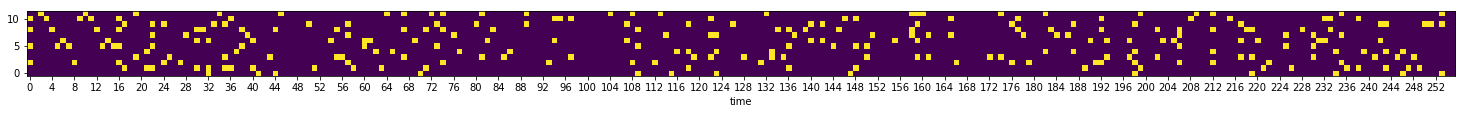

In [19]:
drawNotes(gen)

In [20]:
ms.play()

In [21]:
ms = MySong(song, finished=True)

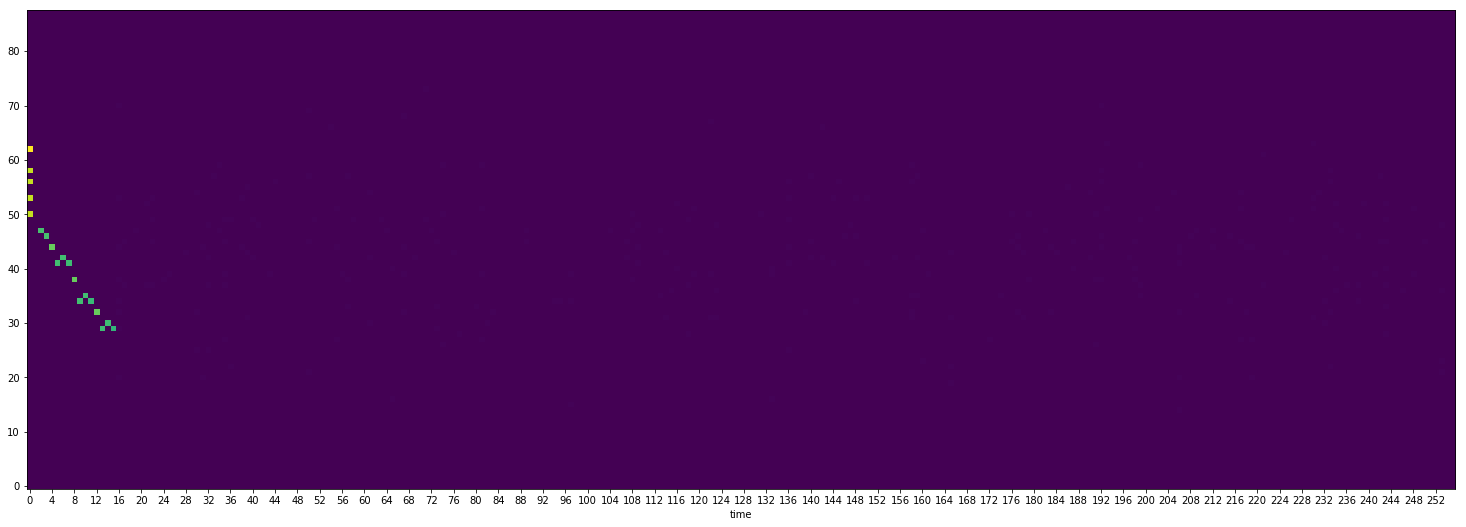

In [22]:
drawNotes(song)

In [ ]:
ms.play()

In [112]:
ms.save_file("greats 4096")

In [ ]:
finale = np.zeros((0, 88))
for r in res:
    finale = np.vstack([finale, np.zeros((8, 88))])
    finale = np.vstack([finale, r[16:]])

In [ ]:
finale.shape

In [ ]:
finale = finale[:28760]

In [ ]:
ms = MySong(finale, finished=True)

In [ ]:
ms.save_file("4. Conditional Voices and HistoryUser and Metalearning 0.00001")